## Dense posterior interpolation in a GaussMarkov (OU) model

This demo shows how to:
- Start from a discretized linear Gaussian state space model (OU process)
- Run Kalman filtering and RauchTungStriebel smoothing on a coarse grid of observations
- Obtain posterior on a refined time grid by inserting virtual steps (no updates)
- Visualize posterior mean, 95% bands, true path, observations, and posterior samples

Key idea: refine the time grid and apply the same SDE-derived transition `Phi(h), Q(h)` between adjacent refined steps. At refined steps without observations we only predict; at observed steps we update. Smoothing then yields dense-time posteriors.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

np.random.seed(8)

@dataclass
class OUParams:
    theta: float  # mean-reversion rate (>0)
    sigma: float  # diffusion scale (>0)


def ou_discrete_params(theta: float, sigma: float, dt: float):
    """Return exact discrete-time transition for 1D OU: x_{t+dt} = phi x_t + w, w~N(0,q).

    phi = exp(-theta dt)
    q   = sigma^2 * (1 - exp(-2 theta dt)) / (2 theta)
    """
    phi = float(np.exp(-theta * dt))
    if theta <= 0:
        raise ValueError("theta must be > 0 for OU")
    q = float((sigma ** 2) * (1.0 - np.exp(-2.0 * theta * dt)) / (2.0 * theta))
    return phi, q


def simulate_ou(T: float, dt: float, params: OUParams, x0: float = 0.0):
    """Simulate 1D OU path using exact discretization.

    Returns times (N+1,), states (N+1,).
    """
    num_steps = int(np.round(T / dt))
    t = np.linspace(0.0, T, num_steps + 1)
    x = np.zeros(num_steps + 1)
    x[0] = x0
    phi, q = ou_discrete_params(params.theta, params.sigma, dt)
    std_w = np.sqrt(max(q, 0.0))
    for k in range(num_steps):
        w = std_w * np.random.randn()
        x[k + 1] = phi * x[k] + w
    return t, x


def generate_observations(t: np.ndarray, x_true: np.ndarray, obs_every: int, r_std: float):
    """Generate noisy observations y_k = x(t_k) + r_k at a coarse subset of grid indices.

    obs_every: take every obs_every-th time index of t as an observation time.
    Returns: obs_mask (bool array), y (same shape as t with NaNs where no obs), obs_indices.
    """
    n = len(t)
    obs_mask = np.zeros(n, dtype=bool)
    obs_mask[::obs_every] = True
    y = np.full(n, np.nan)
    noise = r_std * np.random.randn(obs_mask.sum())
    y[obs_mask] = x_true[obs_mask] + noise
    obs_indices = np.nonzero(obs_mask)[0]
    return obs_mask, y, obs_indices



/var/folders/7x/8rk5f_057bxdbtdkhq27866m0000gn/T/ipykernel_22294/1200730576.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10' if num_samples <= 10 else 'tab20', num_samples)


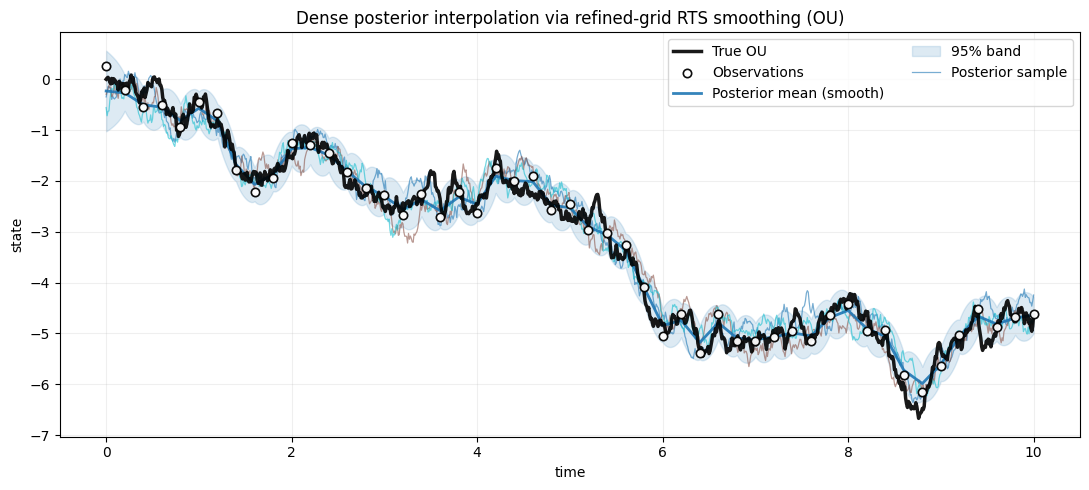

In [13]:
# Configuration
T = 10.0
dt = 0.01  # refined grid step for dense output
params = OUParams(theta=0.01, sigma=0.9)
r_std = 0.2
r_var = r_std ** 2
x0_true = 0.0

# Simulate true OU on refined grid
tr, x_true = simulate_ou(T=T, dt=dt, params=params, x0=x0_true)
N = len(tr) - 1

# Generate sparse observations
obs_every = 20  # observe every 20th step (i.e., every 0.2 seconds)
obs_mask, y_all, obs_indices = generate_observations(tr, x_true, obs_every=obs_every, r_std=r_std)

# Exact discrete transition at dt
phi, q = ou_discrete_params(params.theta, params.sigma, dt)

# Allocate arrays for KF
m_filt = np.zeros(N + 1)
P_filt = np.zeros(N + 1)
m_pred = np.zeros(N + 1)
P_pred = np.zeros(N + 1)

# Prior
m_filt[0] = 0.0
P_filt[0] = 1.0
m_pred[0] = m_filt[0]
P_pred[0] = P_filt[0]

# Forward pass (filtering)
for k in range(N):
    # Predict to k+1
    m_pred[k + 1] = phi * m_filt[k]
    P_pred[k + 1] = (phi ** 2) * P_filt[k] + q

    if obs_mask[k + 1]:
        # Update
        S = P_pred[k + 1] + r_var
        K = P_pred[k + 1] / S
        innov = y_all[k + 1] - m_pred[k + 1]
        m_filt[k + 1] = m_pred[k + 1] + K * innov
        P_filt[k + 1] = (1.0 - K) * P_pred[k + 1]
    else:
        # No observation
        m_filt[k + 1] = m_pred[k + 1]
        P_filt[k + 1] = P_pred[k + 1]

# Backward pass (RTS smoother)
m_smooth = m_filt.copy()
P_smooth = P_filt.copy()

for k in range(N - 1, -1, -1):
    denom = P_pred[k + 1]
    if denom <= 0:
        J = 0.0
    else:
        J = (P_filt[k] * phi) / denom
    m_smooth[k] = m_filt[k] + J * (m_smooth[k + 1] - m_pred[k + 1])
    P_smooth[k] = P_filt[k] + J * J * (P_smooth[k + 1] - P_pred[k + 1])

# Simulation smoother: sample posterior trajectories
num_samples = 3
samples = np.zeros((num_samples, N + 1))

# Precompute square roots for numerical stability
P_s_clipped = np.maximum(P_smooth, 0.0)
P_f_clipped = np.maximum(P_filt, 0.0)
P_p_clipped = np.maximum(P_pred, 0.0)

for s in range(num_samples):
    # Sample terminal state
    samples[s, N] = m_smooth[N] + np.sqrt(P_s_clipped[N]) * np.random.randn()
    # Backward conditional sampling
    for k in range(N - 1, -1, -1):
        denom = P_p_clipped[k + 1]
        if denom <= 0:
            J = 0.0
            cond_var = P_f_clipped[k]
        else:
            J = (P_f_clipped[k] * phi) / denom
            cond_var = P_f_clipped[k] - (J ** 2) * denom
            cond_var = max(cond_var, 0.0)
        mean_k = m_filt[k] + J * (samples[s, k + 1] - m_pred[k + 1])
        samples[s, k] = mean_k + np.sqrt(cond_var) * np.random.randn()

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(11, 5))

ax.plot(tr, x_true, color='k', lw=2.5, alpha=0.9, label='True OU', zorder=4)
ax.scatter(tr[obs_mask], y_all[obs_mask], s=36, facecolor='white', edgecolor='k', linewidth=1.2, alpha=0.95, label='Observations', zorder=5)

ax.plot(tr, m_smooth, color='tab:blue', lw=2.0, alpha=0.9, label='Posterior mean (smooth)', zorder=3)
std = np.sqrt(np.maximum(P_smooth, 0.0))
ax.fill_between(tr, m_smooth - 1.96 * std, m_smooth + 1.96 * std, color='tab:blue', alpha=0.15, label='95% band', zorder=1)

cmap = plt.cm.get_cmap('tab10' if num_samples <= 10 else 'tab20', num_samples)
for s in range(num_samples):
    ax.plot(tr, samples[s], color=cmap(s), lw=0.9, alpha=0.6, label='Posterior sample' if s == 0 else None, zorder=2)

ax.set_xlabel('time')
ax.set_ylabel('state')
ax.set_title('Dense posterior interpolation via refined-grid RTS smoothing (OU)')
ax.legend(loc='upper right', ncol=2)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()
